In [14]:
import numpy as np
from sdtw import SoftDTW
from sdtw.distance import SquaredEuclidean
import matplotlib.pyplot as plt
from sdtw.path import gen_all_paths
from random import randint


# Time series 1: numpy array, shape = [m, d] where m = length and d = dim
#X = ...
# Time series 2: numpy array, shape = [n, d] where n = length and d = dim
#Y = ...

t1 = np.arange(100)
t2 = np.arange(120)
X = np.cos(t1).reshape(-1, 1)
Y = 0.5*np.cos(t2 + 1 + 0.5*np.pi).reshape(-1, 1)
Z = 2.0*np.cos(t1 + 1).reshape(-1, 1)

# D can also be an arbitrary distance matrix: numpy array, shape [m, n]
D = SquaredEuclidean(X, Y)
sdtw = SoftDTW(D, gamma=1.0)
# soft-DTW discrepancy, approaches DTW as gamma -> 0
value = sdtw.compute()
# gradient w.r.t. D, shape = [m, n], which is also the expected alignment matrix
E = sdtw.grad()
# gradient w.r.t. X, shape = [m, d]
G = D.jacobian_product(E)
mat = gen_all_paths(10,20)


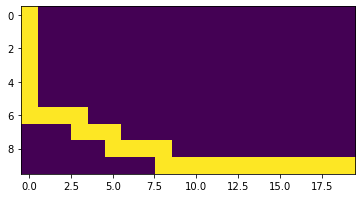

In [23]:
# print(value)
# plt.plot(t,X)
# plt.plot(t,Y)
for i in range(0, randint(0,10**2)):
    next(mat)
plt.imshow(next(mat))
a, b = np.nonzero(next(mat))

In [25]:
len(b)

28

In [8]:
Dxx = SquaredEuclidean(X, X)
Dxy = SquaredEuclidean(X, Y)
Dxz = SquaredEuclidean(X, Z)

sdtw_xx = SoftDTW(Dxx, gamma=1.0)
sdtw_xy = SoftDTW(Dxy, gamma=1.0)
sdtw_xz = SoftDTW(Dxz, gamma=1.0)

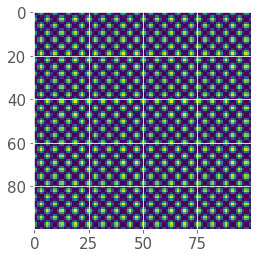

In [8]:
plt.imshow(Dxx.compute())

In [ ]:
sdtw.compute()

In [ ]:
sdtw_xy.R_

In [1]:
import numpy as np

import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15

from sdtw.barycenter import sdtw_barycenter
from sdtw.dataset import load_ucr

X_tr = load_ucr("GunPoint")[0]

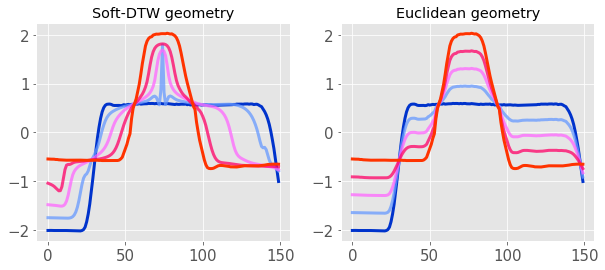

In [3]:
X1, X2 = X_tr[7], X_tr[37]

init_25 = 0.25 * X1 + 0.75 * X2
init_50 = 0.50 * X1 + 0.50 * X2
init_75 = 0.75 * X1 + 0.25 * X2

bary_25 = sdtw_barycenter([X1, X2], init_25, gamma=1, max_iter=100,
                          weights=[0.25, 0.75])
bary_50 = sdtw_barycenter([X1, X2], init_50, gamma=1, max_iter=100,
                          weights=[0.50, 0.50])
bary_75 = sdtw_barycenter([X1, X2], init_75, gamma=1, max_iter=100,
                          weights=[0.75, 0.25])

colors = [
    (0, 51./255, 204./255),
    (102./255, 153./255, 255./255),
    (255./255, 102./255, 255./255),
    (255./255, 0, 102./255),
    (1.0, 51./255, 0),
]


fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(121)

ax.plot(X1.ravel(), c=colors[0], lw=3)
ax.plot(bary_75, c=colors[1], lw=3, alpha=0.75)
ax.plot(bary_50, c=colors[2], lw=3, alpha=0.75)
ax.plot(bary_25, c=colors[3], lw=3, alpha=0.75)
ax.plot(X2.ravel(), c=colors[4], lw=3)
ax.set_title("Soft-DTW geometry")

ax = fig.add_subplot(122)

ax.plot(X1.ravel(), c=colors[0], lw=3)
ax.plot(init_75, c=colors[1], lw=3, alpha=0.75)
ax.plot(init_50, c=colors[2], lw=3, alpha=0.75)
ax.plot(init_25, c=colors[3], lw=3, alpha=0.75)
ax.plot(X2.ravel(), c=colors[4], lw=3)
ax.set_title("Euclidean geometry")

plt.show()

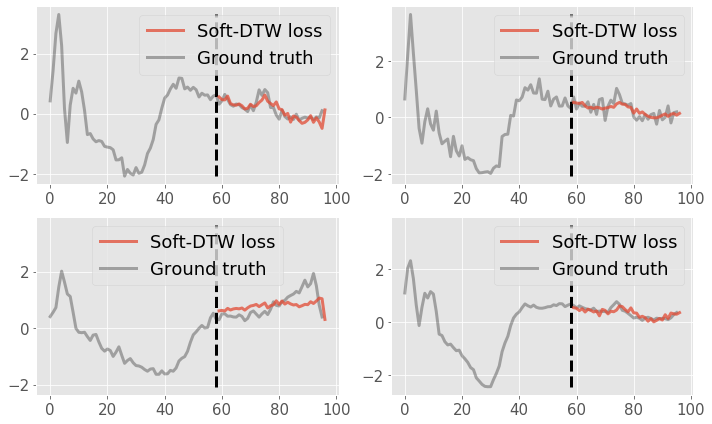

In [13]:
import copy

import numpy as np

from chainer import training
from chainer import iterators, optimizers, serializers
from chainer import Chain
import chainer.functions as F
import chainer.links as L
from chainer.datasets import tuple_dataset

from sdtw.dataset import load_ucr
from sdtw.chainer_func import SoftDTWLoss

import matplotlib.pylab as plt
import matplotlib.font_manager as fm
plt.style.use('ggplot')
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15


def split_time_series(X_tr, X_te, proportion=0.6):
    len_ts = X_tr.shape[1]
    len_input=int(round(len_ts * proportion))
    len_output=len_ts - len_input

    return np.float32(X_tr[:, :len_input, 0]), \
           np.float32(X_tr[:, len_input:, 0]), \
           np.float32(X_te[:, :len_input, 0]), \
           np.float32(X_te[:, len_input:, 0])


class MLP(Chain):

    def __init__(self, len_input, len_output, activation="tanh", n_units=50):
        self.activation = activation

        super(MLP, self).__init__(
            mid = L.Linear(len_input, n_units),
            out=L.Linear(n_units, len_output),
        )

    def __call__(self, x):
        # Given the current observation, predict the rest.
        xx = self.mid(x)
        func = getattr(F, self.activation)
        h = func(xx)
        y = self.out(h)
        return y


class Objective(Chain):

    def __init__(self, predictor, loss="euclidean", gamma=1.0):
        self.loss = loss
        self.gamma = gamma
        super(Objective, self).__init__(predictor=predictor)

    def __call__(self, x, t):
        y = self.predictor(x)

        if self.loss == "euclidean":
            return F.mean_squared_error(y, t)

        elif self.loss == "sdtw":
            loss = 0
            for i in range(y.shape[0]):
                y_i = F.reshape(y[i], (-1,1))
                t_i = F.reshape(t[i], (-1,1))
                loss += SoftDTWLoss(self.gamma)(y_i, t_i)
            return loss

        else:
            raise ValueError("Unknown loss")


def train(network, loss, X_tr, Y_tr, X_te, Y_te, n_epochs=30, gamma=1):
    model= Objective(network, loss=loss, gamma=gamma)

    #optimizer = optimizers.SGD()
    optimizer = optimizers.Adam()
    optimizer.setup(model)

    train = tuple_dataset.TupleDataset(X_tr, Y_tr)
    test = tuple_dataset.TupleDataset(X_te, Y_te)

    train_iter = iterators.SerialIterator(train, batch_size=1, shuffle=True)
    test_iter = iterators.SerialIterator(test, batch_size=1, repeat=False,
                                         shuffle=False)
    updater = training.StandardUpdater(train_iter, optimizer)
    trainer = training.Trainer(updater, (n_epochs, 'epoch'))

    trainer.run()


if __name__ == '__main__':
    import os
    import sys

    try:
        dbname = sys.argv[1]
    except IndexError:
        dbname = "ECG200"

    X_tr, _, X_te, _ = load_ucr("ECG200")

    proportion = 0.6
    n_units = 10
    n_epochs = 30
    gamma = 1
    warm_start = True

    X_te_ = X_te
    X_tr, Y_tr, X_te, Y_te = split_time_series(X_tr, X_te, proportion)

    len_input = X_tr.shape[1]
    len_output = Y_tr.shape[1]

    networks = [MLP(len_input, len_output, n_units=n_units),]
    losses = ["sdtw",]
    labels = ["Soft-DTW loss",]

    for i in range(len(networks)):
        if warm_start and i >= 1:
            # Warm-start with Euclidean-case solution
            networks[i].mid = copy.deepcopy(networks[0].mid)
            networks[i].out = copy.deepcopy(networks[0].out)

        train(networks[i], losses[i], X_tr, Y_tr, X_te, Y_te,
          n_epochs=n_epochs, gamma=gamma)

    max_vals = []
    min_vals = []

    fig = plt.figure(figsize=(10,6))

    pos = 220

    for i in range(min(X_te.shape[0], 4)):
        pos += 1
        ax = fig.add_subplot(pos)

        inputseq = np.array([X_te[i]])  # Need to wrap as minibatch...

        # Plot predictions.
        for idx, label in enumerate(labels):
            output = networks[idx](inputseq)
            output = np.squeeze(np.array(output.data))

            ax.plot(range(len_input + 1,len_input + len(output) + 1),
                     output,
                     alpha=0.75,
                     lw=3,
                     label=label,
                     zorder=10)

            max_vals.append(output.max())
            min_vals.append(output.min())

        # Plot ground-truth time series.
        ground_truth = X_te_[i]
        max_vals.append(ground_truth.max())
        min_vals.append(ground_truth.min())
        ax.plot(ground_truth,
                 c="k",
                 alpha=0.3,
                 lw=3,
                 label='Ground truth',
                 zorder=5)

        # Plot vertical line.
        ax.plot([len_input, len_input],
                 [np.min(min_vals), np.max(max_vals)], lw=3, ls="--", c="k")

        # Legend.
        prop = fm.FontProperties(size=18)
        ax.legend(loc="best", prop=prop)

    fig.set_tight_layout(True)
    plt.show()


In [15]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F


In [ ]:

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio

def my_custom_loss(output, target):
    loss = torch.norm((output-target))**2
    
    return loss

torch.manual_seed(1)    # reproducible

x = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1)  # x data (tensor), shape=(100, 1)
y = torch.sin(x)  #+ 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)
z = torch.cos(x)
#y = np.sqrt(1 - z**2)



# torch can only train on Variable, so convert them to Variable
x, y = Variable(z), Variable(y)
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "blue")
#plt.scatter(x1, y.data.numpy(), color = "blue")
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent variable')
plt.savefig('curve_2_biggernet.png')
plt.show()

# another way to define a network
net = torch.nn.Sequential(
        torch.nn.Linear(1, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 1),
    )

optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
#loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

my_images = []
fig, ax = plt.subplots(figsize=(16,10))
lam = 0.001
# start training
for t in range(2000):
  
    prediction = net(x)     # input x and predict based on x
    loss = my_custom_loss(prediction, y)
    #loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    for p in net.parameters():
        p.data[torch.abs(p.data)<lam] = 0
        #p.data.clamp_(0)
    
    if t % 10 == 0:
        # plot and show learning process
        plt.cla()
        ax.set_title('Regression Analysis - model 3', fontsize=35)
        ax.set_xlabel('Independent variable', fontsize=24)
        ax.set_ylabel('Dependent variable', fontsize=24)
        ax.set_xlim(-11.0, 13.0)
        ax.set_ylim(-1.1, 1.2)
        ax.scatter(x.data.numpy(), y.data.numpy(), color = "blue")
        #ax.scatter(x1, y.data.numpy(), color = "blue")
        ax.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)
        #ax.plot(x1, prediction.data.numpy(), 'g-', lw=3)
        ax.text(8.8, -0.8, 'Step = %d' % t, fontdict={'size': 24, 'color':  'red'})
        ax.text(8.8, -0.95, 'Loss = %.4f' % loss.data.numpy(),
                fontdict={'size': 24, 'color':  'red'})

        # Used to return the plot as an image array 
        # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        my_images.append(image)
    
    


# save images as a gif    
imageio.mimsave('./curve_2_model_3.gif', my_images, fps=10)



In [57]:
# for p in net.parameters():
    
    
#     print(p.data)

x1 = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1)

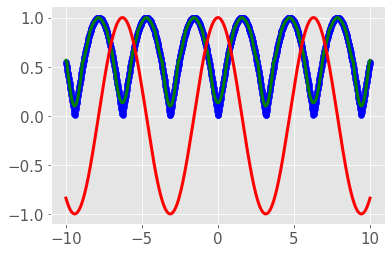

In [86]:
plt.scatter(x1, y.data.numpy(), color = "blue")
plt.plot(x1, prediction.data.numpy(), 'g-', lw=3)
plt.plot(x1, z.data.numpy(), 'r-', lw=3)
plt.show()

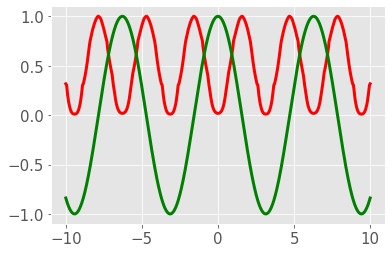

In [90]:
plt.plot(x1, (prediction.data.numpy())**2, 'r-', lw=3)
plt.plot(x1, z.data.numpy(), 'g-', lw=3)

In [91]:
np.shape(X_tr)

(100, 58)

In [117]:
np.shape(X_tr)


(100, 96)

In [112]:
X_tr, y_tr, X_te, y_te = load_ucr("ECG200")
X_tr = X_tr[:,:,0]
X_te = X_te[:,:,0]

1


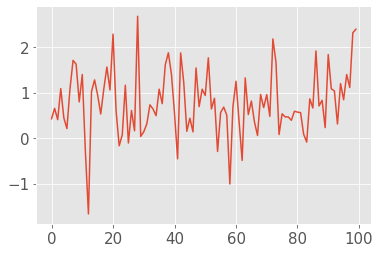

In [127]:
idx =0
plt.plot(X_te[:,idx])
print(y_te[idx])
plt.show()

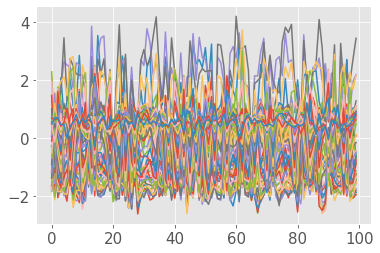

In [97]:
plt.plot(X_tr)
plt.show()